In [ ]:
#Team: Regit
#Project: Privacy Preserving Credit Card Fraud Analysis
#Members: Jatan Loya, Tejas Bana, Siddhant Kulkarni

In [ ]:
#Install TenSeal (Wrapper for SEAL)
!pip3 install tenseal

In [ ]:
#Importing dependencies: PyTorch, pandas, numpy, matplotlib
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Downloading dataset from GDrive
!gdown --id 18Z6ZrdDtZJU-YFTLJILLkwi_-4OneoJm

  8%|▊         | 5.00M/66.0M [00:00<00:02, 29.4MB/s]

100%|██████████| 66.0M/66.0M [00:00<00:00, 71.1MB/s]


In [ ]:
#Reading the dataset
dataset = pd.read_csv("./creditcard.csv")
print("Few Entries: ")
print(dataset.head())
print("Dataset Shape: ", dataset.shape)
print("Maximum Transaction Value: ", np.max(dataset.Amount))
print("Minimum Transaction Value: ", np.min(dataset.Amount))

Few Entries: 
   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]
Dataset Shape:  (284807, 31)
Maximum Transaction Value:  25691.16
Minimum Transaction Value:  0.0


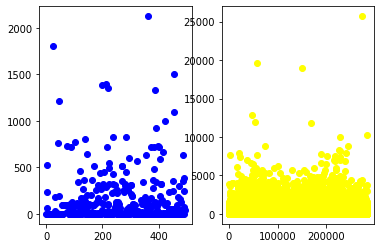

In [ ]:
#Plotting a scatterplot for the dataset
color = {1:'blue',0:'yellow'}
fraudlist = dataset[dataset.Class == 1]
notfraudlist = dataset[dataset.Class == 0]
fig,axes = plt.subplots(1,2)
axes[0].scatter(list(range(1,fraudlist.shape[0]+1)),fraudlist.Amount,color='blue')
axes[1].scatter(list(range(1,notfraudlist.shape[0]+1)),notfraudlist.Amount,color='yellow')
plt.show()


In [ ]:
#Returns the number of unique class values
values = np.array(df["Class"].values)
np.unique(values, return_counts=True)

(array([0, 1]), array([284315,    492]))

In [ ]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def credit_card_data():
    data = pd.read_csv("./creditcard.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["Time"])
    # balance data
    grouped = data.groupby('Class')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["Class"].values).float().unsqueeze(1)
    data = data.drop("Class", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = credit_card_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([689, 29])
y_train has shape: torch.Size([689, 1])
x_test has shape: torch.Size([295, 29])
y_test has shape: torch.Size([295, 1])
#######################################


In [ ]:
#Defining the class of linear regression model
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [ ]:
#We have used SGD optimiser and Binary Cross entropy as Loss
n_features = x_train.shape[1]
model = LR(n_features)
optim = torch.optim.SGD(model.parameters(), lr=1)
criterion = torch.nn.BCELoss()


In [ ]:
#Number of epochs for training and the training function
EPOCHS = 15

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.26793885231018066
Loss at epoch 2: 0.2589355409145355
Loss at epoch 3: 0.25133609771728516
Loss at epoch 4: 0.2448013871908188
Loss at epoch 5: 0.2390972077846527
Loss at epoch 6: 0.2340555638074875
Loss at epoch 7: 0.2295524626970291
Loss at epoch 8: 0.22549419105052948
Loss at epoch 9: 0.22180868685245514
Loss at epoch 10: 0.21843957901000977


In [ ]:
#Accuracy of model on plaintext test_set
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.9152542352676392


In [ ]:
#Defining class of encrypted Linear Regression Model
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):

        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        

#Functions for encrypting and decrypting data
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

eelr = EncryptedLR(model)

In [ ]:
#Setting the parameters for FHE is very important since it has direct impact on
#Speed and accuracy of the model

poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
#Creating TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
#Setting Global scale for ciphertext
ctx_eval.global_scale = 2 ** 20
#Generating Galois keys for dot product operations
ctx_eval.generate_galois_keys()



In [ ]:
#Encrypting the Test dataset
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 0 seconds


In [ ]:
#Written function for encrypted evaluation of the model
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparaison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    
    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)
    

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

#Our accuracy is better on the encrypted model as compared to plaintext eval

Evaluated test_set of 295 entries in 2 seconds
Accuracy: 273/295 = 0.9254237288135593
Difference between plain and encrypted accuracies: -0.010169506072998047
Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...


In [ ]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
 
        self.weight -= self._delta_w * (1 / 2*self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / 2*self._count)
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        #Using approximation of sigmoid function
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):

        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
#Again setting the parameters for FHE operations
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# Creating TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [ ]:
import tenseal as ts

bits_scale = 40

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384+16384,
    coeff_mod_bit_sizes=[40, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 40]
)

#Setting Global scale
context.global_scale = pow(2, bits_scale)

#Galois keys for ciphertext rotations
context.generate_galois_keys()
context.generate_relin_keys()

In [ ]:
#Encrypting training dataset
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 17 seconds


Distribution on plain data:


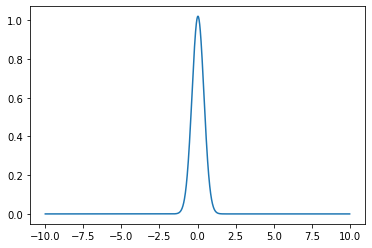

Distribution on encrypted data:


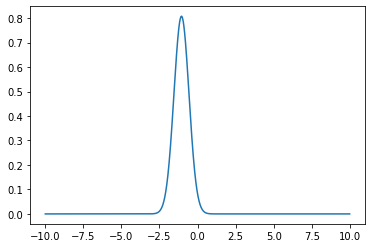

In [ ]:
#Plotting distribution of plaintext and encrypted data
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# Plaintext distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# Encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [ ]:
#Training the model on encrypted data
#Training for fewer epochs since FHE is very compute intensive
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(1):
    eelr.encrypt(ctx_training)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.7423728704452515
Accuracy at epoch #1 is 0.8711864352226257

Average time per epoch: 148 seconds
Final accuracy is 0.8711864352226257
Difference between plain and encrypted accuracies: 0.04406780004501343


In [ ]:
#There is difference of 4% in accuracy between plaintext model and model trained
#on encrypted data which is very close given less time for parameters tweaking